In [38]:
import data_helpers as dh
import bo_problem as bp
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Preprocess Data

Our work relies only on publicly accessible data on the NYCOpenData portal. We crucially rely on two data sets: [Forestry Service Requests](https://data.cityofnewyork.us/Environment/Forestry-Service-Requests/mu46-p9is/about_data) and [Forestry Inspections](https://data.cityofnewyork.us/Environment/Forestry-Inspections/4pt5-3vv4/about_data). These two datasets are actively maintained, and we further host the exact version of these two datasets that we used, retrieved both on December 1st, 2023.

Merging Forestry Service Requests and Forestry Inspections to get a single data frame to pass into the simulator. The resulting data frame contains, crucially, the following informaiton: (1) a unique identifier of service request, (2) created date of this service request, (3) Category and Type of the incident associated with this service request, (4) BoroughCode, indicating the location of this service request, (5) if inspected, an InspectionDate, otherwise NaT.

In [5]:
merged_data = dh.read_raw_and_filter()

In [6]:
merged_data.head(3)

,ServiceRequestGlobalID,InspectionDate,SRCategory,SRType,BoroughCode,ServiceRequestParentGlobalID,GlobalID,CreatedDate,IncidentGlobalID
0,EA39EFB4-FBEF-4E03-BC28-D221C6B70945,2019-10-11,Prune,Prune Dead Wood,Queens,NaN,EA39EFB4-FBEF-4E03-BC28-D221C6B70945,2019-10-11,EA39EFB4-FBEF-4E03-BC28-D221C6B70945
1,FD3D23D6-0CB8-40F6-AA19-D311F1DA469E,2019-01-10,Remove Tree,Tree Removal,Staten Island,NaN,FD3D23D6-0CB8-40F6-AA19-D311F1DA469E,2019-01-08,FD3D23D6-0CB8-40F6-AA19-D311F1DA469E
2,NaN,NaT,Plant Tree,Street Tree,Brooklyn,NaN,0C527DF5-618F-45C2-8757-D2E320583562,2023-06-11,0C527DF5-618F-45C2-8757-D2E320583562


## Running Bayesian Optimization Loop

The file `run_bo.py` contains code needed to perform the Bayesian optimization routine; the optimization problem is defined in `bo_problem.py`, and the simulator on which the optimization is done is defined in `simulator.py`.

Below, we present an example of running the Bayesian optimization for 4 iterations. We simulate the Borough-budget case (`--city_budget 0`), with non-inspections equal to a 100 day delay `--drop_cost 100`, and SLA defined as the median delay (`--obj "delay_median"`). The equity objective is the weighted sum of the maximal difference in SLAs of the same category of incidents among all Boroughs (`--equity "varsla"`)

The exact results in the paper were obtained by settting `batch_size = 64`, `n_step = 50`, and varying the values for the following arguments

``
city_budget in [0, 1];
drop_cost in [50, 100]
obj in ["delay_median", "delay_75"];
equity in ["varsla", "max"];
``

In [11]:
! python run_bo.py --batch_size 4 --n_step 2 --city_budget 0 --drop_cost 100 --obj "delay_median" --equity "varsla"

initialized problem with dimension  65
city budget: 0
byborough_policy: 1
drop_by_age: 0
obj: delay_median
drop_cost: 100
equity_objective: varsla
Running qNEHVI with 4 initial points on 65 objectives
Getting initial sample of 4...
(260,)

Model 1 fitted
Sampler 1 defined
Optimizing 1...
(260,)

Optimization 1 done

Batch  1: Hypervolume (qNEHVI) = (195.88), 
Ref point = tensor([-37.6192, -36.4500], dtype=torch.float64), 
Best solution = tensor([-29.5959, -10.3000], dtype=torch.float64), time = 150.68.

# Evaluating Policies

Here we reproduce Figure 2c and tables containing details about the outcome of the most equitable policy in the paper, by evaluating the most equitable policy found from Bayesian optimzization.

In [16]:
import torch
policy = torch.load('./example_policy/most_equitable_x.pt')

In [18]:
format = bp.format_x(policy)

borough_budgets:
    Bronx  Brooklyn  Manhattan  Queens  Staten Island
0  0.142     0.345      0.103   0.245          0.165
inspection_policy:
                      Bronx  Brooklyn  Manhattan  Queens  Staten Island
Hazard               0.148     0.323      0.113   0.289          0.228
Illegal Tree Damage  0.222     0.230      0.192   0.259          0.166
Other                0.108     0.120      0.192   0.275          0.189
Prune                0.060     0.000      0.056   0.000          0.091
Remove Tree          0.220     0.139      0.194   0.177          0.325
Root/Sewer/Sidewalk  0.243     0.188      0.253   0.000          0.000
target_service_fractions:
                      Bronx  Brooklyn  Manhattan  Queens  Staten Island
Hazard               0.651     0.671      0.312   0.102          0.189
Illegal Tree Damage  0.118     0.368      0.419   0.284          0.343
Other                0.522     0.497      0.690   0.255          0.763
Prune                0.601     0.057      0.222 

In [19]:
# running a simulation loop to evaluate this policy
sim = bp.simulation_loop_eval(
        policy.numpy(), 
        obj = "delay_median",
        drop_cost = 100, 
        date_start = '2019-01-01',
        date_end = '2019-12-31',
        equity="varsla"
    )

In [30]:
outcomes = bp.format_df_objectives(sim.df_objectives, "delay_median")

delay_median 
                      Bronx  Brooklyn  Manhattan  Queens  Staten Island
Hazard                 4.0       5.0        2.0     4.0            3.0
Illegal Tree Damage    1.0       1.0        1.0     1.0            1.0
Other                  1.0       1.0        1.0     1.0            1.0
Prune                 11.0      11.0        4.0     7.0            6.0
Remove Tree            1.0       4.0        2.0     5.0            1.0
Root/Sewer/Sidewalk    1.0       2.0        1.0     7.0           15.0

frac_inspected
                      Bronx  Brooklyn  Manhattan  Queens  Staten Island
Hazard                0.91      0.95       0.88    0.57           0.91
Illegal Tree Damage   1.00      1.00       0.97    0.99           0.99
Other                 1.00      1.00       0.98    0.98           1.00
Prune                 0.68      0.05       0.57    0.02           0.86
Remove Tree           0.98      0.90       0.89    0.57           0.99
Root/Sewer/Sidewalk   0.99      0.95       0.

In [36]:
shape = bp.get_shape_for_map(sim)

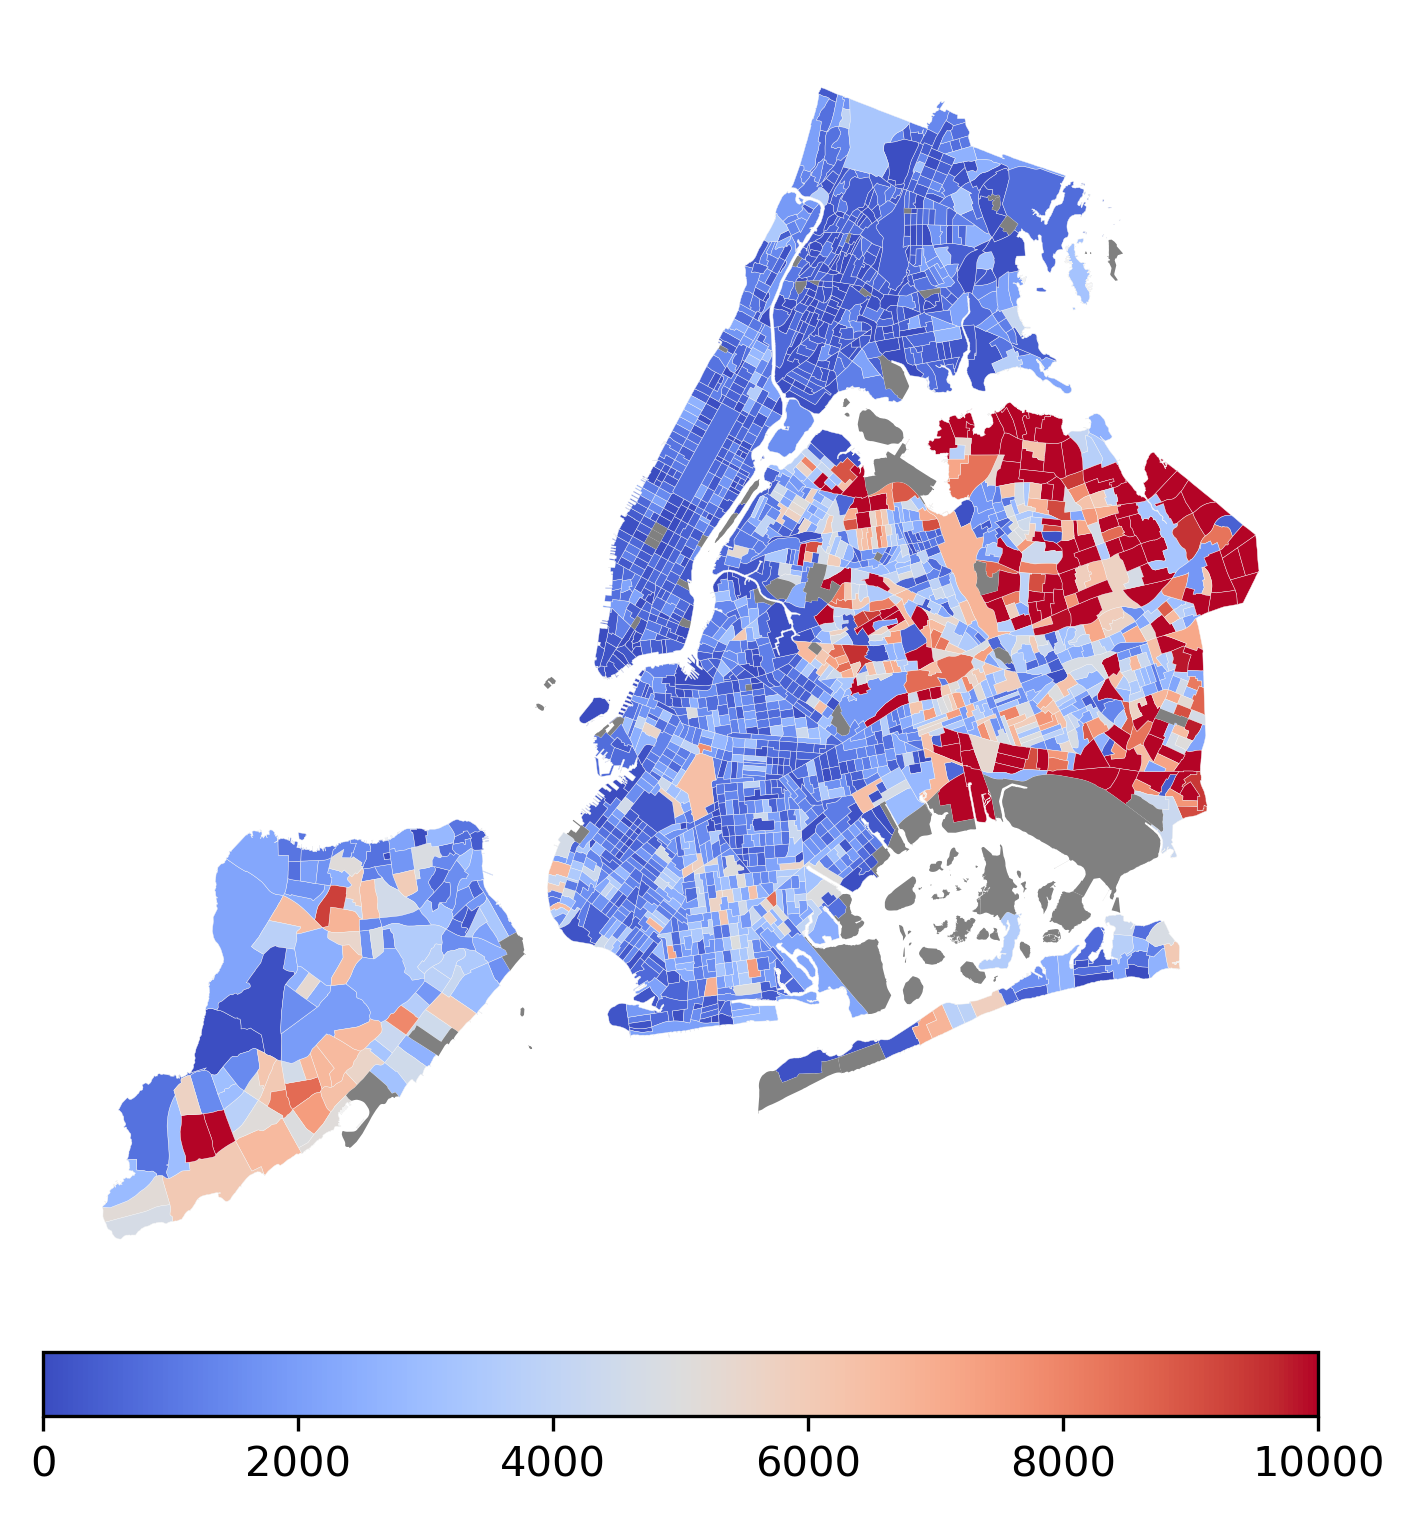

In [44]:
vmin = 0
vmax =10000
fig, ax = plt.subplots(1, figsize=(10, 6), dpi=300)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
shape.plot(column='total_cost', cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='0.95', vmin=vmin, vmax=vmax)
shape[shape.total_cost.isna()].plot(color='gray', ax=ax)
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.8, fraction=0.046, pad=0.04) 